In [121]:
%matplotlib notebook
import sys
sys.path.append('..')
from __future__ import print_function
from matplotlib.widgets import RectangleSelector
import numpy as np
import matplotlib.pyplot as plt
from lightjob.cli import load_db
import re
import h5py
import json
import pandas as pd
from lasagnekit.misc.plot_weights import dispims_color
from ipywidgets import interact, interactive, fixed

In [122]:
# storing global variables
class Singleton(object):
    img_plot = None
    rectangle_selector = None
    tsne_df = None
    err = []
    X_model = None
    
# matplotlib interactive stuff
def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    try:
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        w, h = 28, 28 # mnist dim
        x = np.array(Singleton.tsne_df['x'])
        y = np.array(Singleton.tsne_df['y'])
        tsne_filter = ((x >= x1) &
                       (x <= x2) &
                       (y >= y1) &
                       (y <= y2))
        tsne_df = Singleton.tsne_df.iloc[tsne_filter]
        indices = tsne_df['ind']

        if len(indices) == 0:
            Singleton.img_plot.set_data(Singleton.img_plot.get_array() * 0)
            return
        samples = Singleton.X_model[indices]
        samples = samples.reshape((samples.shape[0], w, h, 1)) * np.ones((1, 1, 1, 3))
        img = dispims_color(samples, border=1, bordercolor=(10, 10, 10))
        Singleton.img_plot.set_data(img)
    except Exception as ex:
        Singleton.err.append(str(ex))

def toggle_selector(event):
    if event.button:
        Singleton.img_plot.set_data(Singleton.img_plot.get_array() * 0)
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        sys.stdout.flush()
        Singleton.rectangle_selector.set_active(False)
        Singleton.img_plot.set_data(Singleton.img_plot.get_array() * 0)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        sys.stdout.flush()
        Singleton.rectangle_selector.set_active(True)
        Singleton.img_plot.set_data(Singleton.img_plot.get_array() * 0)

# job retrieval
def retrieve_job(pattern, db):
    J = db.jobs_with(state='success', type='generation')
    
    J = filter(lambda j: re.match(pattern, j['summary']), J)
    if len(J) == 0:
        raise Exception('Not found : {}'.format(pattern))
    return np.random.choice(J)

def get_full_job_id(j):
    return j['summary']

def get_data_slice(X, id_):
    js = json.loads(X.attrs[id_])
    return slice(js['start'], js['end'])

In [123]:
db = load_db()

{u'backend': u'Dataset'}


In [124]:
dataset = h5py.File('../figs/dataset.hdf5', 'r')
X = dataset['X']

In [220]:
def show(id_pattern=''):
    j = retrieve_job(id_pattern, db)
    id_ = get_full_job_id(j)

    X_model = X[get_data_slice(X, id_)]
    Singleton.X_model = X_model
    tsne_df = pd.read_csv('../jobs/results/{}/tsne_input.csv'.format(id_))
    Singleton.tsne_df = tsne_df

    fig = plt.figure(figsize=(15, 15))

    ax1 = plt.subplot2grid((5, 6), (0, 0), colspan=3, rowspan=2)
    ax2 = plt.subplot2grid((5, 6), (0, 3), colspan=2, rowspan=2)

    ax1.scatter(tsne_df['x'], tsne_df['y'], marker='+')

    Singleton.rectangle_selector = RectangleSelector(
        ax1, line_select_callback,
        drawtype='box', useblit=True,
        button=[1, 3],  # don't use middle button
        minspanx=5, mtrinspany=5,
        spancoords='pixels',
        interactive=True)
    img_plot = ax2.imshow(np.zeros((20, 20)), interpolation='none', cmap='gray')
    Singleton.img_plot = img_plot
    plt.connect('key_press_event', toggle_selector)
    plt.connect('button_press_event', toggle_selector)
    plt.title(id_)
    plt.tight_layout()

    plt.show()

<IPython.core.display.Javascript object>


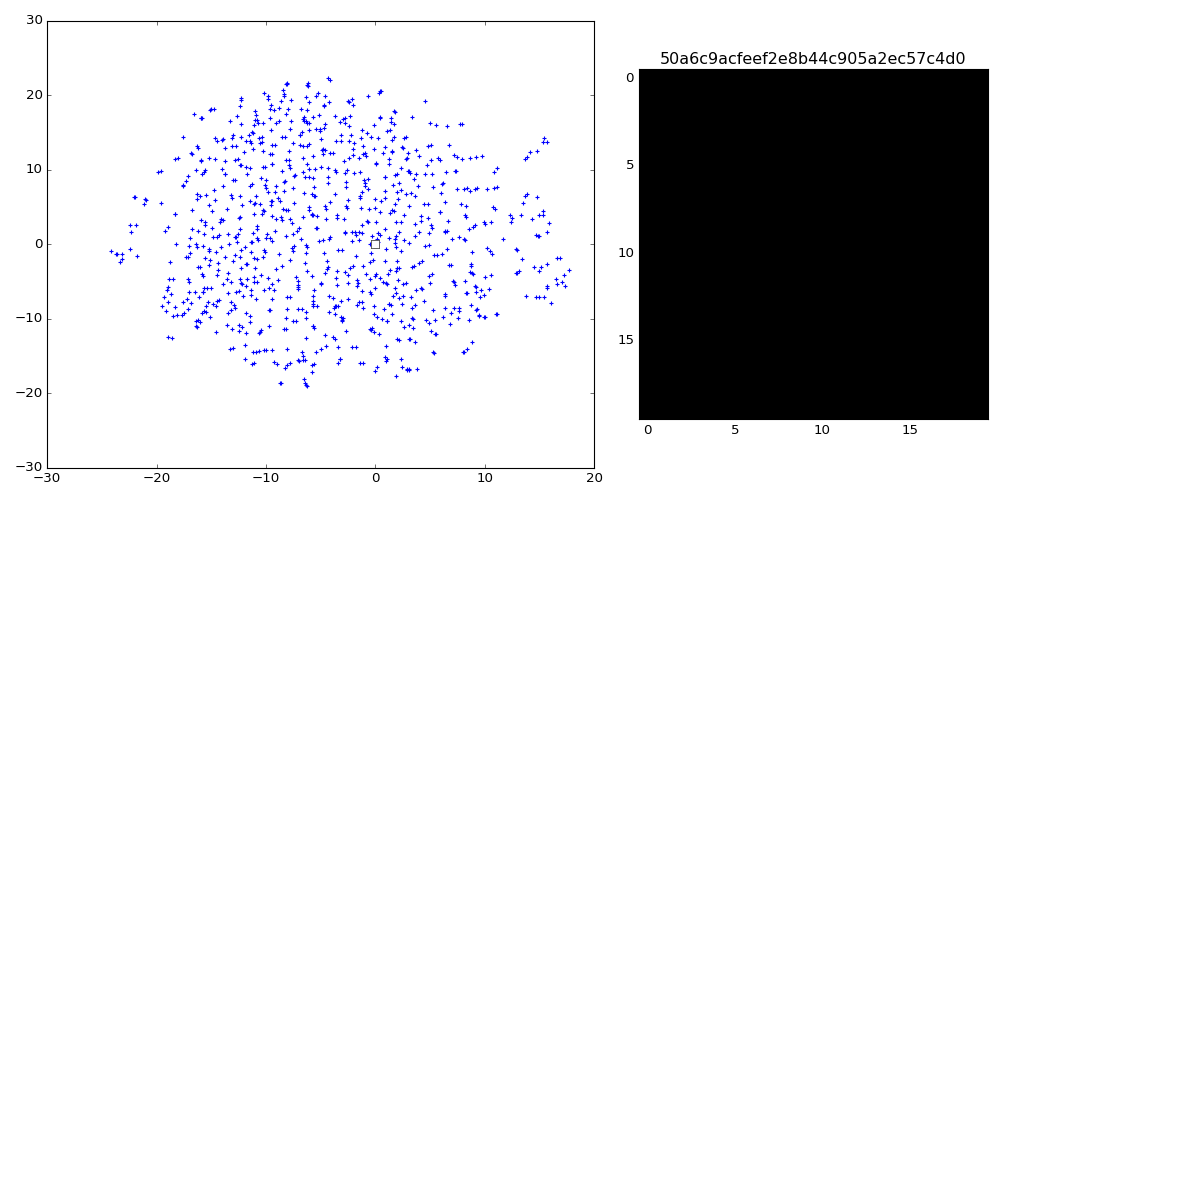

In [222]:
interact(show, __manual=True)